Copyright 2017 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.



# E-Z NSynth

__Neural Audio Synthesis of Musical Notes with WaveNet Autoencoders, ICML 2017__

Jesse Engel, Cinjon Resnick, Adam Roberts, Sander Dieleman, Douglas Eck, Karen Simonyan, Mohammad Norouzi

## Instructions
* This colab notebook has everything you need to upload your own sounds and use NSynth models to reconstruct and interpolate between them.
* You can use these sounds as samples in your own music a la [Andrew Huang Rocking Out with NSynth](https://www.youtube.com/watch?v=AaALLWQmCdI).
* Make sure to use a kernel with a GPU attached by selecting: **Edit >> Notebook Settings >> Hardware Accelerator >> GPU** from the dropdown menu.
* You can run this notebook without writing / seeing a line of code. Just click the triangular **"Play"** button on the left of each cell.
* Start at the top and work your way to the bottom, clicking **"Play"** for each cell.
* If you want to see the code, you can reveal with the menu on the upper right hand side of each cell.


### Other Resources:
* [Nat and Friends "Behind the scenes"](https://www.youtube.com/watch?v=BOoSy-Pg8is)
* [Original Blog Post](https://magenta.tensorflow.org/nsynth)
* [NSynth Instrument](https://magenta.tensorflow.org/nsynth-instrument)
* [Jupyter Notebook Tutorial](https://magenta.tensorflow.org/nsynth-fastgen)
* [ArXiv Paper](https://arxiv.org/abs/1704.01279)
* [Github Code](https://github.com/tensorflow/magenta/tree/main/magenta/models/nsynth)



# Setup Environment

We need to start downloading and choosing a pretrained NSynth model to use. Transfers several GBs, may take a minute or two. Just click Play...

In [5]:
#@title Setup Environment
#@test {"output": "ignore"}


# Install magenta
print('Installing Magenta...\n')
!pip install -qU magenta
print('Installing ffmpeg...\n')
!echo "Yes" | apt-get install ffmpeg > /dev/null


print('Downloading Pretrained Models...\n')
# Copy checkpoints from google cloud
# Copying 1GB, takes a minute
print('Getting Instruments Model...\n')
!gsutil -q -m cp -R gs://download.magenta.tensorflow.org/models/nsynth/wavenet-ckpt.tar /content/
print('Getting Voices Model...\n')
!gsutil -q -m cp -R gs://download.magenta.tensorflow.org/models/nsynth/wavenet-voice-ckpt.tar.gz /content/
!cd /content/
!tar -xvf wavenet-ckpt.tar > /dev/null
!tar -xvf wavenet-voice-ckpt.tar.gz > /dev/null


print('Importing Modules...\n')
# Load modules and helper functions
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
%matplotlib inline

from google.colab import files
from magenta.models.nsynth import utils
from magenta.models.nsynth.wavenet import fastgen
from note_seq.notebook_utils import colab_play as play

def upload(sample_length, sr):
  '''Upload a .wav file.'''
  filemap = files.upload()
  file_list, audio_list = [], []
  for key, value in filemap.items():
    fname = os.path.join('/content/', key)
    with open(fname, 'wb') as f:
      f.write(value)
    audio = utils.load_audio(fname, sample_length=sample_length, sr=sr)
    file_list.append(fname)
    audio_list.append(audio)
  return file_list, audio_list

download = files.download

get_name = lambda f: os.path.splitext(os.path.basename(f))[0]

print('Sucess!! Environment is now setup.')


Installing Magenta...

Installing ffmpeg...


Getting Instruments Model...

Getting Voices Model...

Importing Modules...

Sucess!! Environment is now setup.


We have two pretrained models to choose from. One trained on the individual instrument notes of the [NSynth Dataset](https://magenta.tensorflow.org/datasets/nsynth) ("Instruments"), and another trained on a variety of voices in the wild for an art project ("Voices", mixture of singing and speaking). The Instruments model was trained on a larger quantity of data, so tends to generalize a bit better. Neither reconstructs audio perfectly, but both add their own unique character to sounds. Explore them both and see what you like!

In [6]:
#@title Choose a Model { vertical-output: true, run: "auto" }
Model = "Instruments" #@param ["Instruments", "Voices"] {type:"string"}
ckpts = {'Instruments': '/content/wavenet-ckpt/model.ckpt-200000',
         'Voices': '/content/wavenet-voice-ckpt/model.ckpt-200000'}

ckpt_path = ckpts[Model]
print('Using model pretrained on %s.' % Model)

Using model pretrained on Instruments.


# Load Sound Files

Now it's time for you to load your own sound files for processing. You can use either `.wav` files or `.mp3` files, but in either case they will be converted to `.wav`. All files will be downsampled to 16kHz and cropped / silence padded to `Length` seconds as the input and output to the algorithm.

Don't have sounds? You can downloaded free sounds from freesound.org For example:
* https://freesound.org/people/MustardPlug/sounds/395058/
* https://freesound.org/people/cms4f/sounds/159119/
* https://freesound.org/people/juskiddink/sounds/60055/
* https://freesound.org/people/Audeption/sounds/418526/
* https://freesound.org/people/Jagadamba/sounds/255878/


Keep in mind, with the cloud GPU synthesis takes around 4 minutes / 1 second of length.

In [7]:
#@title Set Sound Length (in Seconds) { vertical-output: true, run: "auto" }
Length = 2.0 #@param {type:"number"}
SR = 16000
SAMPLE_LENGTH = int(SR * Length)

Put all your sound files into a single folder and maker sure to select all the files you want to reconstruct / interpolate between. **(Ctrl/Cmd/Shift Click)**

In [ ]:
#@title Upload sound files (.wav, .mp3)

try:
  file_list, audio_list = upload(sample_length=SAMPLE_LENGTH, sr=SR)
  names = [get_name(f) for f in file_list]
  # Pad and peak normalize
  for i in range(len(audio_list)):
    audio_list[i] = audio_list[i] / np.abs(audio_list[i]).max()

    if len(audio_list[i]) < SAMPLE_LENGTH:
      padding = SAMPLE_LENGTH - len(audio_list[i])
      audio_list[i] = np.pad(audio_list[i], (0, padding), 'constant')

  audio_list = np.array(audio_list)
except Exception as e:
  print('Upload Cancelled')
  print(e)

# Encode

Next we need to encode the audio. This should be relatively fast on a GPU, we will also create interpolations (the midpoints between each encoding) from which to re-synthesize audio.

In [9]:
#@title Generate Encodings
audio = np.array(audio_list)
z = fastgen.encode(audio, ckpt_path, SAMPLE_LENGTH)
print('Encoded %d files' % z.shape[0])


# Start with reconstructions
z_list = [z_ for z_ in z]
name_list = ['recon_' + name_ for name_ in names]

# Add all the mean interpolations
n = len(names)
for i in range(n - 1):
  for j in range(i + 1, n):
    new_z = (z[i] + z[j]) / 2.0
    new_name = 'interp_' + names[i] + '_X_'+ names[j]
    z_list.append(new_z)
    name_list.append(new_name)

print("%d total: %d reconstructions and %d interpolations" % (len(name_list), n, len(name_list) - n))

INFO:tensorflow:Restoring parameters from /content/wavenet-ckpt/model.ckpt-200000
Encoded 1 files
1 total: 1 reconstructions and 0 interpolations


For fun, we can take a look at the encoding of our audio files. They are compressed representations of the audio but have some structure in their own right, (16 numbers, kind of like 16 channels of audio, so there are 16 different lines, colors are arbitrary). 

Voice 008


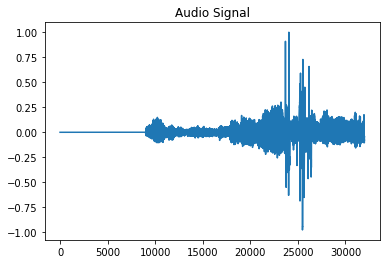

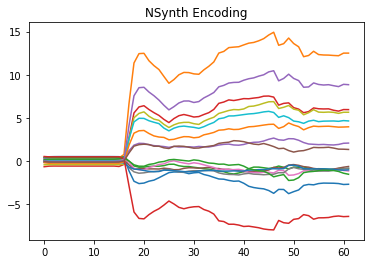

In [10]:
#@title Visualize Audio and Encoding { vertical-output: true, run: "auto" }
SoundFile = 0 #@param {type:"slider", min:0, max:10, step:1}
file_number = SoundFile

try:
  print(names[file_number])
  play(audio_list[file_number], sample_rate=SR)
  # fig, axs = plt.subplots(2, 1, figsize=(12, 10))
  plt.figure()
  plt.plot(audio_list[file_number])
  plt.title('Audio Signal')

  plt.figure()
  plt.plot(z_list[file_number])
  plt.title('NSynth Encoding')
except Exception as e:
  print(e)

# Synthesize

On the GPU, this should take about 4 minutes per 1 second of audio per a batch.

In [11]:
#@title Synthesize Interpolations
print('Total Iterations to Complete: %d\n' % SAMPLE_LENGTH)

encodings = np.array(z_list)
save_paths = ['/content/' + name + '.wav' for name in name_list]
fastgen.synthesize(encodings,
                   save_paths=save_paths,
                   checkpoint_path=ckpt_path,
                   samples_per_save=int(SAMPLE_LENGTH / 10))

Total Iterations to Complete: 32000

INFO:tensorflow:Restoring parameters from /content/wavenet-ckpt/model.ckpt-200000
INFO:tensorflow:Sample: 0
INFO:tensorflow:Saving: /content/recon_Voice 008.wav
INFO:tensorflow:Sample: 100
INFO:tensorflow:Sample: 200
INFO:tensorflow:Sample: 300
INFO:tensorflow:Sample: 400
INFO:tensorflow:Sample: 500
INFO:tensorflow:Sample: 600
INFO:tensorflow:Sample: 700
INFO:tensorflow:Sample: 800
INFO:tensorflow:Sample: 900
INFO:tensorflow:Sample: 1000
INFO:tensorflow:Sample: 1100
INFO:tensorflow:Sample: 1200
INFO:tensorflow:Sample: 1300
INFO:tensorflow:Sample: 1400
INFO:tensorflow:Sample: 1500
INFO:tensorflow:Sample: 1600
INFO:tensorflow:Sample: 1700
INFO:tensorflow:Sample: 1800
INFO:tensorflow:Sample: 1900
INFO:tensorflow:Sample: 2000
INFO:tensorflow:Sample: 2100
INFO:tensorflow:Sample: 2200
INFO:tensorflow:Sample: 2300
INFO:tensorflow:Sample: 2400
INFO:tensorflow:Sample: 2500
INFO:tensorflow:Sample: 2600
INFO:tensorflow:Sample: 2700
INFO:tensorflow:Sample: 2800

In [12]:
#@title Download Interpolations
for fname in save_paths:
  print('Downloading: %s' % fname.split('/')[-1])
  download(fname)

Downloading: recon_Voice 008.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
#@title Listen to the outputs

print("Originals:\n")
for fname in file_list:
  synth_audio = utils.load_audio(fname,
                                 sample_length=SAMPLE_LENGTH,
                                 sr=SR)
  print(get_name(fname))
  play(synth_audio, sample_rate=SR)

for i, fname in enumerate(save_paths):
  if i == 0:
    print("Reconstructions:\n")
  if i == len(file_list):
    print("Interpolations:\n")
  synth_audio = utils.load_audio(fname,
                                 sample_length=SAMPLE_LENGTH,
                                 sr=SR)
  print(get_name(fname))
  play(synth_audio, sample_rate=SR)

Originals:



/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Voice 008


Reconstructions:

recon_Voice 008
